In [12]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

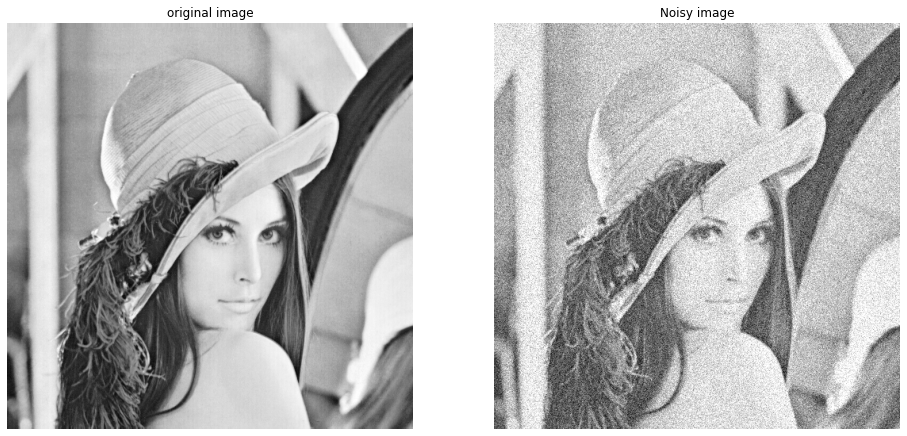

In [13]:
# read the image with OpenCV
original_img: np.ndarray = cv2.imread('lena.png')
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB) / 255.0
original_img = original_img[:,:,0]
img = original_img + np.random.normal(loc=0.0, scale=0.1, size=original_img.shape)
img = np.clip(img, 0.0, 1.0)

fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()
axs[0].axis('off')
axs[0].set_title('original image')
axs[0].imshow(original_img, cmap = 'gray')

axs[1].axis('off')
axs[1].set_title('Noisy image')
axs[1].imshow(img, cmap = 'gray')

noisy_image = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float()

In [14]:
class TVDenoise(torch.nn.Module):
    def __init__(self, noisy_image):
        super(TVDenoise, self).__init__()
        self.l2_term = torch.nn.MSELoss(reduction='mean')
        self.clean_image = torch.nn.Parameter(data=noisy_image.clone(), requires_grad=True)
        self.noisy_image = noisy_image

    def gradh(self, x):
        k_h = np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]]).astype(np.float32)
        kernel_h = torch.tensor(k_h).unsqueeze(0).unsqueeze(0)
        return torch.nn.functional.conv2d(x, kernel_h.float(), stride=1, padding=1)

    def gradv(self, x):
        k_v = np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]]).astype(np.float32)
        kernel_v = torch.tensor(k_v).unsqueeze(0).unsqueeze(0)
        return torch.nn.functional.conv2d(x, kernel_v.float(), stride=1, padding=1)

    def grad2d(self, x):
        return torch.stack([self.gradh(x),self.gradv(x)])

    def forward(self):
        image_grad = self.grad2d(self.clean_image)
        l1_reg = torch.norm(image_grad, 1)
        return self.l2_term(self.clean_image, self.noisy_image) + 0.0001 * l1_reg

    def get_clean_image(self):
        return self.clean_image

In [15]:
tv_denoiser = TVDenoise(noisy_image)
optimizer = torch.optim.SGD(tv_denoiser.parameters(), lr=0.1, momentum=0.9)

num_iters = 1000
for i in range(num_iters):
    optimizer.zero_grad()
    loss = tv_denoiser()
    if i % 25 == 0:
        print("Loss in iteration {} of {}: {:.3f}".format(i, num_iters, loss.item()))
    loss.backward()
    optimizer.step()


Loss in iteration 0 of 1000: 5.867
Loss in iteration 25 of 1000: 5.537
Loss in iteration 50 of 1000: 5.078
Loss in iteration 75 of 1000: 4.640
Loss in iteration 100 of 1000: 4.230
Loss in iteration 125 of 1000: 3.849
Loss in iteration 150 of 1000: 3.497
Loss in iteration 175 of 1000: 3.171
Loss in iteration 200 of 1000: 2.871
Loss in iteration 225 of 1000: 2.596
Loss in iteration 250 of 1000: 2.345
Loss in iteration 275 of 1000: 2.117
Loss in iteration 300 of 1000: 1.912
Loss in iteration 325 of 1000: 1.727
Loss in iteration 350 of 1000: 1.561
Loss in iteration 375 of 1000: 1.414
Loss in iteration 400 of 1000: 1.284
Loss in iteration 425 of 1000: 1.170
Loss in iteration 450 of 1000: 1.070
Loss in iteration 475 of 1000: 0.982
Loss in iteration 500 of 1000: 0.907
Loss in iteration 525 of 1000: 0.841
Loss in iteration 550 of 1000: 0.785
Loss in iteration 575 of 1000: 0.736
Loss in iteration 600 of 1000: 0.694
Loss in iteration 625 of 1000: 0.658
Loss in iteration 650 of 1000: 0.627
Loss i

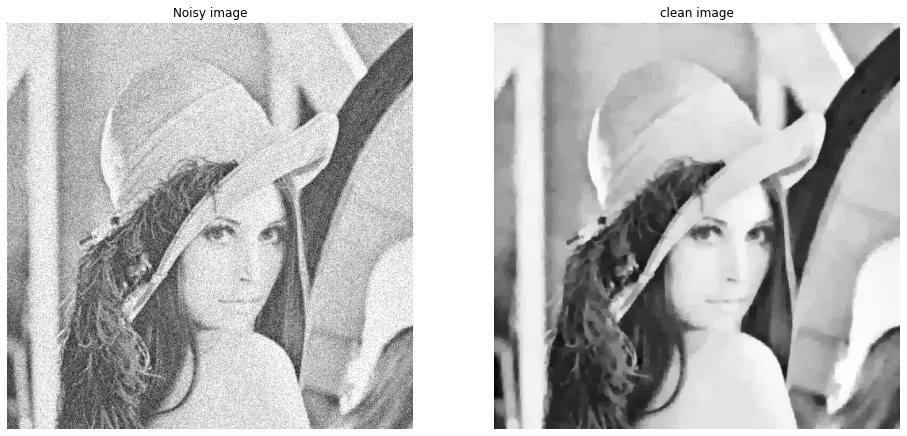

In [16]:
clean_image = tv_denoiser.get_clean_image().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()
axs[0].axis('off')
axs[0].set_title('Noisy image')
axs[0].imshow(img, cmap = 'gray')

axs[1].axis('off')
axs[1].set_title('clean image')
axs[1].imshow(clean_image.squeeze(), cmap = 'gray')